# Preparing Enviroment

In [1]:
# @title Connect To Google Drive
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/Shared drives/CS682 - Project'
notebook_folder = drive_folder + '/Notebooks/'
figures_folder = drive_folder + '/Figures/'
data_folder = drive_folder + '/Dataset/'
model_folder = notebook_folder + 'models/'
%cd {drive_folder}

Mounted at /content/drive
/content/drive/Shared drives/CS682 - Project


In [2]:
# @title Imports

# !pip install --upgrade torch torchvision torchaudio triton
!pip install --upgrade torch diffusers triton
# !pip install --upgrade diffusers accelerate transformers
# !pip install prodigyopt

from torchvision.models import inception_v3
# from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os import path
import numpy as np

import torch
# from torch import nn
from accelerate import Accelerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.0 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# @title CUDA - Shreya's Fav
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


In [ ]:
# @title Load Dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,.5, .5), (0.5,.5,.5))])
dataset = datasets.CIFAR10(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


# Loading Teacher, Inception Model, and Student Model

In [21]:
# @title Loading Teacher Model
model_id = "google/ddpm-cifar10-32"
ddpm = DDPMPipeline.from_pretrained(model_id)
ddpm.to(device)
ddpm_unet = ddpm.unet

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/143M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
# @title Inception Model

# Load Inception Model
inception_model = inception_v3(pretrained=True).to(device)
inception_model.eval()

def register_forward_hook(model):
    feature_output = []

    def get_feature_map(module, input, output):
        feature_output.append(output)  # Store the output in the list

    # Register the hook on the AdaptiveAvgPool2d layer
    hook = model.avgpool.register_forward_hook(get_feature_map)
    # hook = model.Mixed_7c.register_forward_hook(get_feature_map)
    return hook, feature_output


def preprocess_samples(samples):

  # Ensure samples are converted to a tensor and match the input format for the Inception model
  if isinstance(samples, list):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((299, 299)),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tensor_samples = [transform(img).unsqueeze(0) for img in samples]
    images = torch.cat(tensor_samples).to(device)
  else:
    transform = transforms.Compose([
      transforms.Resize((299, 299)),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    images = transform(samples).to(device)
  return images


def get_feature_vectors(samples, model):
  # hook, feature_output = register_forward_hook(model)  # Register hook inside the function
  feature_output = None
  def get_feature_map(module, input, output):
      nonlocal feature_output
      feature_output = output

  # Register the hook on the AdaptiveAvgPool2d layer
  hook = inception_model.avgpool.register_forward_hook(get_feature_map)
  # hook = model.Mixed_7c.register_forward_hook(get_feature_map)
  images = preprocess_samples(samples)

  # Pass images through the feature extractor
  with torch.no_grad():  # Disable gradient calculation
    _ = model(images)  # Obtain feature maps
  # print(feature_output)
  hook.remove()  # Remove the hook after extraction
  return feature_output  # Return the captured feature output from the hook


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 149MB/s] 


In [32]:
# @title Baseline Student

# Define the U-Net model
model = UNet2DModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 256),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
    downsample_padding=0,
    flip_sin_to_cos=False,
    freq_shift=1
).to(device)
print(model.get_memory_footprint(), model.num_parameters())
#
# model = UNet2DModel(
#     sample_size=32,
#     in_channels=3,
#     out_channels=3,
#     layers_per_block=2,
#     block_out_channels=(128, 256, 512),
#     down_block_types=(
#         "DownBlock2D",
#         "AttnDownBlock2D",
#         "DownBlock2D",
#     ),
#     up_block_types=(
#         "UpBlock2D",
#         "AttnUpBlock2D",
#         "UpBlock2D",
#     ),
#     downsample_padding=0,
#     flip_sin_to_cos=False,
#     freq_shift=1

# ).to(device)


noise_scheduler = DDPMScheduler(num_train_timesteps=500, variance_type='fixed_large')
model = UNet2DModel(**{
  "_class_name": "UNet2DModel",
  "_diffusers_version": "0.0.4",
  "act_fn": "silu",
  "attention_head_dim": None,
  "block_out_channels": [
    256,
    512,
  ],
  "center_input_sample": False,
  "down_block_types": [
    "DownBlock2D",
    "AttnDownBlock2D",
  ],
  "downsample_padding": 0,
  "flip_sin_to_cos": False,
  "freq_shift": 1,
  "in_channels": 3,
  "layers_per_block": 2,
  "mid_block_scale_factor": 1,
  "norm_eps": 1e-06,
  "norm_num_groups": 32,
  "out_channels": 3,
  "sample_size": 32,
  "time_embedding_type": "positional",
  "up_block_types": [
    "AttnUpBlock2D",
    "UpBlock2D"
  ]
}).to(device)
print(model.get_memory_footprint(), model.get_memory_footprint())
print(ddpm.unet.get_memory_footprint(), ddpm.unet.get_memory_footprint())

# model = UNet2DModel(sample_size=32, in_channels=3, out_channels=3).to(device)

63723532 15930883
254586892 254586892
142985228 142985228


# Training Student

In [5]:
# @title Load and Save Model

def get_valid_extension(base, extension, other=None):
  counter = 1
  curr_name = f"{base}{extension}" + (f".{other}" if other else "")
  while path.exists(curr_name):
    curr_name = f"{base}{extension}_{counter}" + (f".{other}" if other else "")
    counter+=1
  return curr_name


def save_model(folder_name, model):
  try:
    model.to('cpu')
    new_filename = get_valid_extension(model_folder, folder_name)
    model.save_pretrained(new_filename)
    print(f"Model Saved under {new_filename}")
    model.to(device)
  except Exception as e:
    model.to(device)
    print(f"Model failed to Save: {e}")


def load_model(folder_name, model):
   try:
      dir = path.join(model_folder, folder_name)
      new_model = model.from_pretrained(dir)
      print("Model Loaded")
      new_model.to(device)
      return new_model
   except Exception as e:
        print(f"Model failed to load: {e}")
        return model

def create_plot(data, batch_size, file_path):
  plt.plot((np.arange(len(data))+1)*batch_size, data)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Loss vs Iteration')
  plt.savefig(file_path)
  plt.close()

def validation_loss(model, noise_scheduler, dataloader):
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for images, _ in dataloader:
      images = images.to(device)
      noise = torch.randn(images.shape, device=images.device)
      timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (images.shape[0],), device=images.device)
      noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
      noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
      loss = torch.nn.functional.mse_loss(noise_pred, noise)
      val_loss += loss.item()
  print(f"Validation Loss: {val_loss / len(dataloader)}")
  return val_loss / len(dataloader)

In [ ]:
def training(model, teacher, inception, num_epochs, optimizer, noise_scheduler, teacher_scheduler,  dataloader, validation_dataloader, batch_size, lr_scheduler, ratio=1, ema_model=None):
  curr_loss = []
  accelerator = Accelerator(mixed_precision='fp16')
  model, optimizer, dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, dataloader, lr_scheduler)

  model.train()
  teacher.eval()
  inception.eval()

  for epoch in tqdm(range(num_epochs)):
        for batch_num, (images, _) in enumerate(dataloader):
            images = images.to(device)
            noise = torch.randn(images.shape, device=images.device)

            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (images.shape[0],), device=images.device,
            )

            noisy_images_stu = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred_stu = model(noisy_images_stu, timesteps, return_dict=False)[0]
            feature_student  = get_feature_vectors(noise_pred_stu, inception)

            with torch.no_grad():
              noisy_images_tea = teacher_scheduler.add_noise(images, noise, (ratio*timesteps).to(torch.int64))
              noise_pred_tea = teacher(noisy_images_tea, (ratio*timesteps).to(torch.int64), return_dict=False)[0]
            features_teacher = get_feature_vectors(noise_pred_tea, inception)


            loss2 = torch.nn.functional.mse_loss(feature_student, features_teacher)
            loss1 = torch.nn.functional.mse_loss(noise_pred_stu, noise)

            total_loss = loss1 + loss2

            optimizer.zero_grad(set_to_none=True)
            accelerator.backward(total_loss)
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            curr_loss.append(total_loss.detach().item())
            ema_model.step(model.parameters())

            if batch_num % 25 == 0:
              print(f"Epoch {epoch+1}, Step {batch_num}, Loss: {curr_loss[-1]}, Loss1: {loss1}, Loss2:{loss2} lr: {lr_scheduler.get_last_lr()}")
        validation_loss(model, noise_scheduler, validation_dataloader)
        model.train()
        if epoch % 2 == 0:
          save_model(f"distilled_baseline/new_epoch_{epoch+1}", model)
  return curr_loss


In [6]:
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.training_utils import EMAModel

train_model = False
if train_model:
	batch_size = 128
	lr = 2e-4
	epochs = 15
	optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
	dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=device=='cuda', persistent_workers=True)
	validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=device=='cuda')
	lr_scheduler = get_cosine_schedule_with_warmup(
			optimizer=optimizer,
			num_warmup_steps= (len(dataloader) * epochs)*.1,
			num_training_steps=(len(dataloader) * epochs),
	)

	# ratio = ddpm.scheduler.config.num_train_timesteps/noise_scheduler.config.num_train_timesteps
	teacher = load_model('distilled_baseline_1', ddpm_unet)
	teacher_scheduler = DDPMScheduler(num_train_timesteps=750, variance_type='fixed_large')
	ratio = teacher_scheduler.config.num_train_timesteps/noise_scheduler.config.num_train_timesteps
	ema_model = EMAModel(model.parameters(), decay=.9999)


	model_name = "distilled_inter_to_smaller"
	losses = training(model, teacher, inception_model, epochs, optimizer, noise_scheduler, teacher_scheduler, dataloader, validation_dataloader, batch_size, lr_scheduler, ratio, ema_model)

	# losses = training(model, ddpm_unet, inception_model, epochs, optimizer, noise_scheduler, ddpm.scheduler, dataloader, validation_dataloader, batch_size, lr_scheduler, ratio, ema_model)
	val_loss = validation_loss(model, noise_scheduler, validation_dataloader)
	save_model(model_name, model)
	create_plot(losses, batch_size, get_valid_extension(figures_folder, model_name, 'png'))

else:
	name = 'baseline_model'
	model = load_model(name, model)

Model Loaded


  0%|          | 0/500 [00:00<?, ?it/s]

skipping cudagraphs due to skipping cudagraphs due to cpu device (arg0_1). Found from : 
   File "/usr/local/lib/python3.10/dist-packages/diffusers/models/unets/unet_2d.py", line 276, in forward
    timesteps = timesteps[None].to(sample.device)



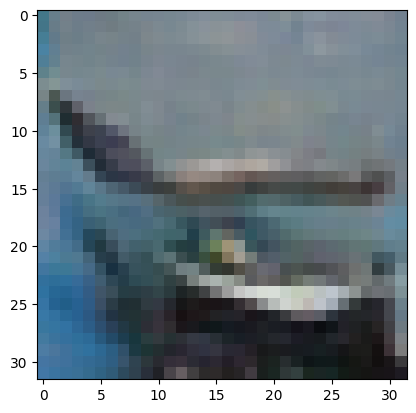

In [8]:
# @title Display Generated Image
# validation_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=device=='cuda')
# validation_loss(model, noise_scheduler, validation_dataloader)
# plt.figure(figsize=(2, 2))
torch.set_float32_matmul_precision('high')
model = torch.compile(model, mode="reduce-overhead", fullgraph=True)
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler).to(device)
plt.imshow(pipeline(num_inference_steps=500).images[0])

In [9]:
# @title Create Dataset
NUM_OF_IMAGES = 10000
image_batch =  1500
current_dataset = data_folder+'baseline/'

for i in range(NUM_OF_IMAGES//image_batch):
  with torch.no_grad():
    images = pipeline(batch_size=image_batch, num_inference_steps=500).images
  for j, img in enumerate(images):
    img.save(current_dataset+f"generated_image_{i*image_batch+j}.png")


  0%|          | 0/500 [00:00<?, ?it/s]

skipping cudagraphs due to skipping cudagraphs due to cpu device (arg0_1). Found from : 
   File "/usr/local/lib/python3.10/dist-packages/diffusers/models/unets/unet_2d.py", line 276, in forward
    timesteps = timesteps[None].to(sample.device)



  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# @title Calulate FID

# !pip install pytorch-fid
# !python -m pytorch_fid {"Dataset/cifar10"} {"Dataset/distilled_baseline"} --device cuda:0
# # !python -m pytorch_fid --save-stats {"Dataset/cifar10"} {"Dataset/cifar10.npz"}


In [ ]:
print(model.get_memory_footprint())